In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
import torch
import numpy as np
import random
import pickle

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

## Load dataset

In [3]:
from personalized_nlp.datasets.wiki.aggression import AggressionDataModule
from personalized_nlp.datasets.wiki.attack import AttackDataModule
from personalized_nlp.datasets.wiki.toxicity import ToxicityDataModule
from personalized_nlp.datasets.wiki.aggression_attack import AggressionAttackDataModule

## Import models

In [4]:
from personalized_nlp.models.baseline import Net
from personalized_nlp.models.onehot import NetOneHot
from personalized_nlp.models.human_bias import HumanBiasNet
from personalized_nlp.models.bias import AnnotatorBiasNet
from personalized_nlp.models.annotator import AnnotatorEmbeddingNet
from personalized_nlp.models.annotator_word import AnnotatorWordEmbeddingNet

from personalized_nlp.settings import STORAGE_DIR
from personalized_nlp.learning.train import train_test
from personalized_nlp.utils.metrics import evaluate_classification, evaluate_regression, get_result_dataframe

In [10]:
data_module = AttackDataModule(embeddings_type='xlmr')

data_module.prepare_data()
data_module.setup()
data_module.compute_word_stats(
    min_word_count=100,
    min_std=0.0, 
    words_per_text=100
)

## Evaluate

In [6]:
seed_everything()

results = []
regression=False

for dataset in ['attack']:
    for embeddings_type in ['bert']:
        
        if dataset == 'attack':
            data_module = AttackDataModule(embeddings_type=embeddings_type)
        elif dataset == 'aggression':
            data_module = AggressionDataModule(embeddings_type=embeddings_type)
        elif dataset =='toxicity':
            data_module = ToxicityDataModule(embeddings_type=embeddings_type)
            
        data_module.prepare_data()
        data_module.setup()
        
        for min_word_count in [100]:#range(100, 320, 20):
            data_module.compute_word_stats(
                min_word_count=min_word_count,
                min_std=0.0, 
                words_per_text=256
            )

            model_type = 'word_embedding'
            embedding_dim = 50

            #pickle.dump(results, open(STORAGE_DIR / 'results/wiki/wiki_word_count_.p', 'wb'))

            for fold_num in range(1):

                hparams = {
                    'dataset': type(data_module).__name__,
                    'model_type': model_type,
                    'embeddings_type': embeddings_type,
                    'embedding_size': embedding_dim,
                    'fold_num': fold_num,
                    'regression': regression,
                    'min_word_count': min_word_count
                }

                output_dim = 2
                text_embedding_dim = data_module.text_embedding_dim
                
                if model_type == 'baseline':
                    model = Net(output_dim=output_dim, text_embedding_dim=text_embedding_dim)
                elif model_type == 'onehot':
                    model = NetOneHot(output_dim=output_dim, annotator_num=data_module.annotators_number, 
                                      text_embedding_dim=text_embedding_dim)
                elif model_type == 'peb':
                    model = HumanBiasNet(output_dim=output_dim, bias_vector_length=len(data_module.class_dims),
                                        text_embedding_dim=text_embedding_dim)
                elif model_type == 'bias':
                    model = AnnotatorBiasNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, 
                                             word_num=data_module.words_number,
                                             annotator_num=data_module.annotators_number)
                elif model_type == 'embedding':
                    model = AnnotatorEmbeddingNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, 
                                                  word_num=data_module.words_number, 
                                                  annotator_num=data_module.annotators_number, dp=0.0, dp_emb=0.25, 
                                                  embedding_dim=embedding_dim, hidden_dim=100)
                elif model_type == 'word_embedding':
                    model = AnnotatorWordEmbeddingNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, 
                                                      word_num=data_module.words_number, 
                                                      annotator_num=data_module.annotators_number, dp=0.0, dp_emb=0.25,
                                                      embedding_dim=embedding_dim, hidden_dim=100)
                
                test_predictions, true_labels, model, timings = train_test(data_module, model, epochs=15, lr=0.008, 
                                                                  regression=regression,
                                                                  use_cuda=True)

                result_metrics = evaluate_classification(test_predictions, 
                                                         true_labels, 
                                                         class_dims=data_module.class_dims)

                result_metrics['training_time'] = timings['training_time']
                result_metrics['testing_time'] = timings['testing_time']

                results.append((hparams, result_metrics))

wandb: Currently logged in as: satyrr (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | AnnotatorWordEmbeddingNet | 8.9 M 
1 | metrics | ModuleDict                | 0     
------------------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.479    Total estimated model params size (MB)


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_a': 0.90328449010849,
 'test_f1_a': 0.6776561737060547,
 'test_loss': 0.24980121850967407,
 'test_macro_f1_a': 0.8103817105293274,
 'test_precision_a': 0.8076862096786499,
 'test_recall_a': 0.5836878418922424}
--------------------------------------------------------------------------------



TypeError: cannot unpack non-iterable NoneType object

## Word Embeddings visualization

In [5]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_context('talk')

In [8]:
offensive_words_idx = data_module.word_stats.index.tolist()

In [9]:
X = model.word_embeddings(torch.tensor(offensive_words_idx).to('cpu')).cpu().detach().numpy()

In [10]:
X_embedded = TSNE(n_components=2, learning_rate=200, perplexity=50).fit_transform(X)
X_embedded.shape

(4019, 2)

In [11]:

df = pd.DataFrame()#data.loc[data.split == 'test'].iloc[:2000].copy()

df['x_0'] = X_embedded[:, 0]
df['x_1'] = X_embedded[:, 1]
df['word'] = [data_module.idx_to_word[i] for i in offensive_words_idx]
df['mean'] = data_module.word_stats['mean'].values
df['std'] = data_module.word_stats['std'].values
#df['entropy'] = data_module.word_stats['entropy'].values
df['word_count'] = data_module.word_stats['word_count'].values
df['word_count_log'] = np.log(data_module.word_stats['word_count'].values)


In [12]:
df.to_csv('./data/wiki_embeddings_visualization/attack_words.csv')

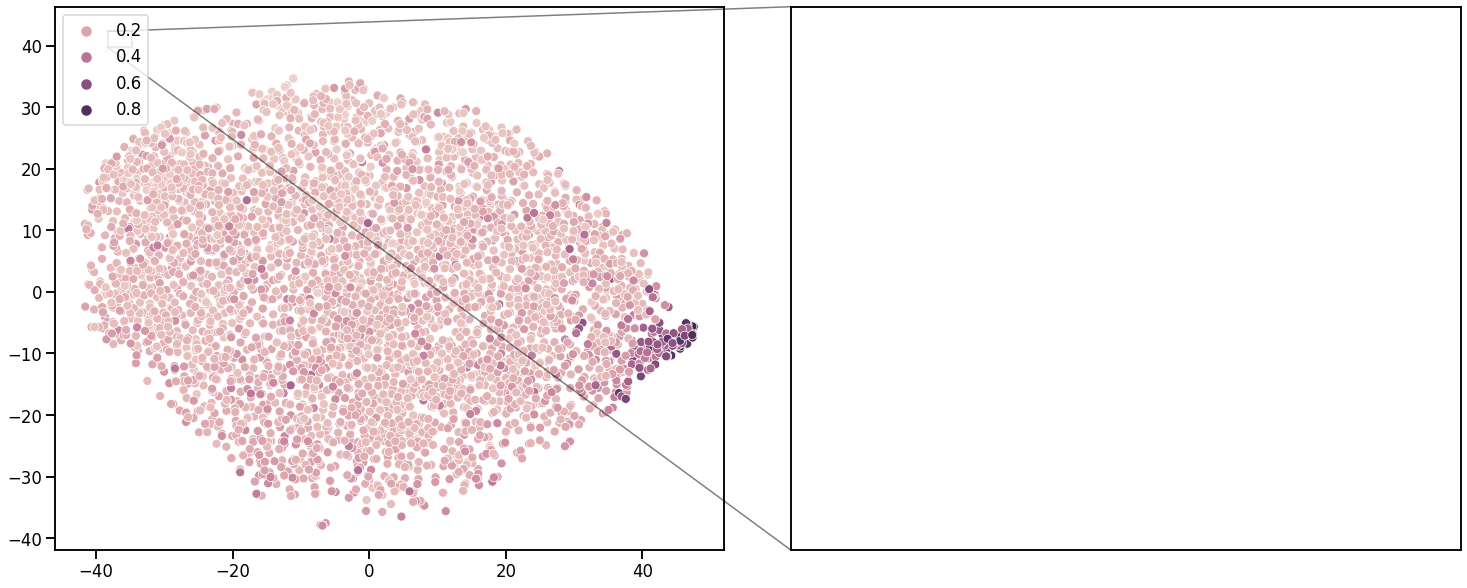

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(12, 10))
ax = fig.gca()


axins = ax.inset_axes([1.1, 0.0, 1, 1])

sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean')
g = sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean', ax=axins, legend=False)

inset_x_min = -38
inset_x_max = -35

inset_y_min = 40
inset_y_max = 42


axins.set_xlim((inset_x_min,inset_x_max))
axins.set_ylim((inset_y_min,inset_y_max))

ax.set_ylabel(None)
ax.set_xlabel(None)
#ax.set_xticks([])
#ax.set_yticks([])

axins.set_ylabel(None)
axins.set_xlabel(None)
axins.set_xticks([])
axins.set_yticks([])

axins.set_ylim((inset_y_min-0.3, inset_y_max+0.3))
axins.set_xlim((inset_x_min-0.3, inset_x_max+0.3))

plt.legend(loc='upper left')

for i, point in df.iterrows():
    if point['x_0'] > inset_x_max or point['x_0'] < inset_x_min:
        continue
    if point['x_1'] > inset_y_max or point['x_1'] < inset_y_min:
        continue
    
    axins.text(point['x_0']+.02, point['x_1'], str(point['word']))
        
ax.indicate_inset_zoom(axins, edgecolor="black")
#plt.show()
#plt.autoscale()
plt.savefig('word_embeddings_mean.pdf', dpi=300, bbox_inches='tight')  


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(12, 10))
ax = fig.gca()


axins = ax.inset_axes([1.1, 0.0, 1, 1])

sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean')
g = sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean', ax=axins, legend=False)

inset_x_min = -51
inset_x_max = -48

inset_y_min = -27
inset_y_max = -24


axins.set_xlim((inset_x_min,inset_x_max))
axins.set_ylim((inset_y_min,inset_y_max))

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_xticks([])
ax.set_yticks([])

axins.set_ylabel(None)
axins.set_xlabel(None)
axins.set_xticks([])
axins.set_yticks([])

axins.set_ylim((inset_y_min-0.3, inset_y_max+0.3))
axins.set_xlim((inset_x_min-0.3, inset_x_max+0.3))

plt.legend(loc='upper left')

for i, point in df.iterrows():
    if point['x_0'] > inset_x_max or point['x_0'] < inset_x_min:
        continue
    if point['x_1'] > inset_y_max or point['x_1'] < inset_y_min:
        continue
    
    axins.text(point['x_0']+.02, point['x_1'], str(point['word']))
        
ax.indicate_inset_zoom(axins, edgecolor="black")
#plt.show()
#plt.autoscale()
plt.savefig('word_embeddings_mean.pdf', dpi=300, bbox_inches='tight')  


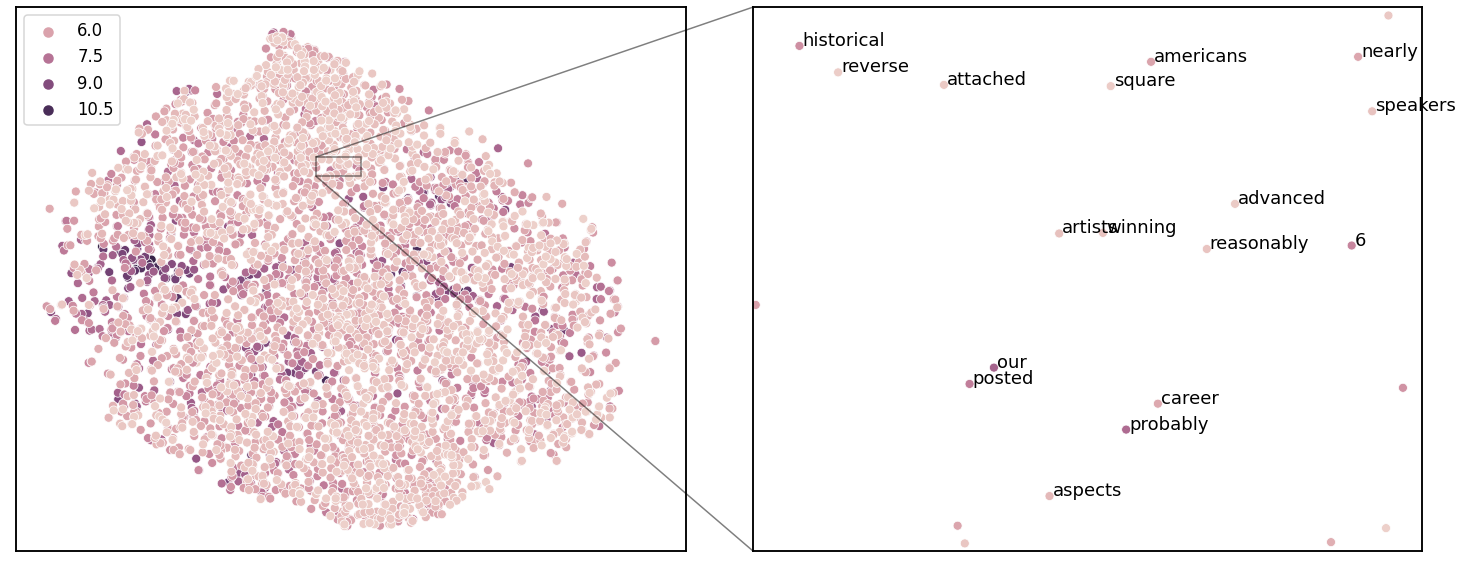

In [14]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12, 10))
ax = fig.gca()


axins = ax.inset_axes([1.1, 0.0, 1, 1])

sns.scatterplot(data=df, x="x_0", y="x_1", hue='word_count_log')
g = sns.scatterplot(data=df, x="x_0", y="x_1", hue='word_count_log', ax=axins, legend=False)

inset_x_min = -2
inset_x_max = 2

inset_y_min = 28
inset_y_max = 32


axins.set_xlim((inset_x_min,inset_x_max))
axins.set_ylim((inset_y_min,inset_y_max))

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_xticks([])
ax.set_yticks([])

axins.set_ylabel(None)
axins.set_xlabel(None)
axins.set_xticks([])
axins.set_yticks([])

axins.set_ylim((inset_y_min-0.3, inset_y_max+0.3))
axins.set_xlim((inset_x_min-0.3, inset_x_max+0.3))

plt.legend(loc='upper left')

for i, point in df.iterrows():
    if point['x_0'] > inset_x_max or point['x_0'] < inset_x_min:
        continue
    if point['x_1'] > inset_y_max or point['x_1'] < inset_y_min:
        continue
    
    axins.text(point['x_0']+.02, point['x_1'], str(point['word']))
        
ax.indicate_inset_zoom(axins, edgecolor="black")
#plt.show()
#plt.autoscale()
plt.savefig('word_embeddings_word_count.pdf', dpi=300, bbox_inches='tight')  


In [24]:
fig = px.scatter(df, x="x_0", y="x_1", hover_data=['word'], color='word_count')

fig.update_traces(marker=dict(
        color = np.log(df['word_count']),
        showscale=True,
        colorscale = 'RdBu'
    ))

fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['x', 'y', 'mean', 'std', 'count'] but received: x_0

## Annotator embeddings visualization

In [14]:
model_annotator_embeddings = model.annotator_embeddings.weight.data.cpu().numpy()[1:]
model_annotator_embeddings.shape

tsne = TSNE(2)
annotator_embeddings_2d = tsne.fit_transform(model_annotator_embeddings)

In [15]:
annotators_embeddings_df = pd.DataFrame(annotator_embeddings_2d)
annotators_embeddings_df.columns = ['x', 'y']
annotators_embeddings_df['annotator_id'] = data_module.annotator_biases.index.values

In [16]:
annotations_df = data_module.annotations

In [17]:
annotator_stats = annotations_df.groupby('annotator_id').agg(['mean', 'std', 'count']).fillna(0).reset_index()
annotator_stats.columns = annotator_stats.columns.map('_'.join)
annotator_stats['annotator_id'] = annotator_stats['annotator_id_']
annotators_embeddings_df = annotators_embeddings_df.merge(annotator_stats, on='annotator_id')

In [18]:
annotations_counts = annotations_df.annotator_id.value_counts().reset_index()
annotations_counts.columns = ['annotator_id_', 'total_count']

annotators_embeddings_df = annotators_embeddings_df.merge(annotations_counts)

In [19]:
annotators_embeddings_df.to_csv('./data/wiki_embeddings_visualization/attack_annotators.csv')

In [6]:
import pandas as pd
import seaborn as sns
annotators_embeddings_df = pd.read_csv('./data/wiki_embeddings_visualization/attack_annotators.csv')

<Figure size 864x720 with 0 Axes>

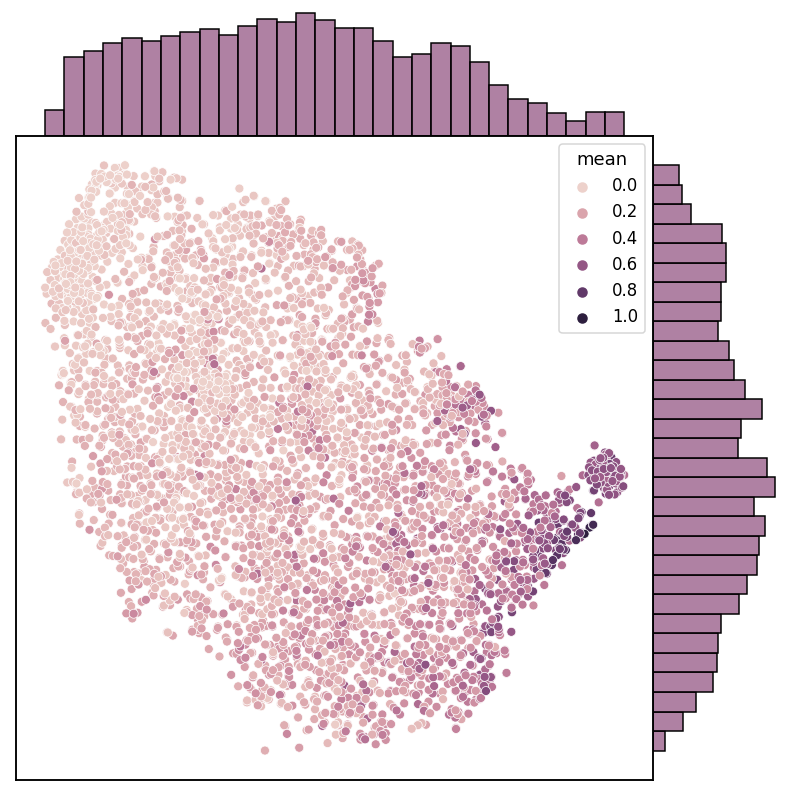

<AxesSubplot:xlabel='Count', ylabel='y'>

<Figure size 864x720 with 0 Axes>

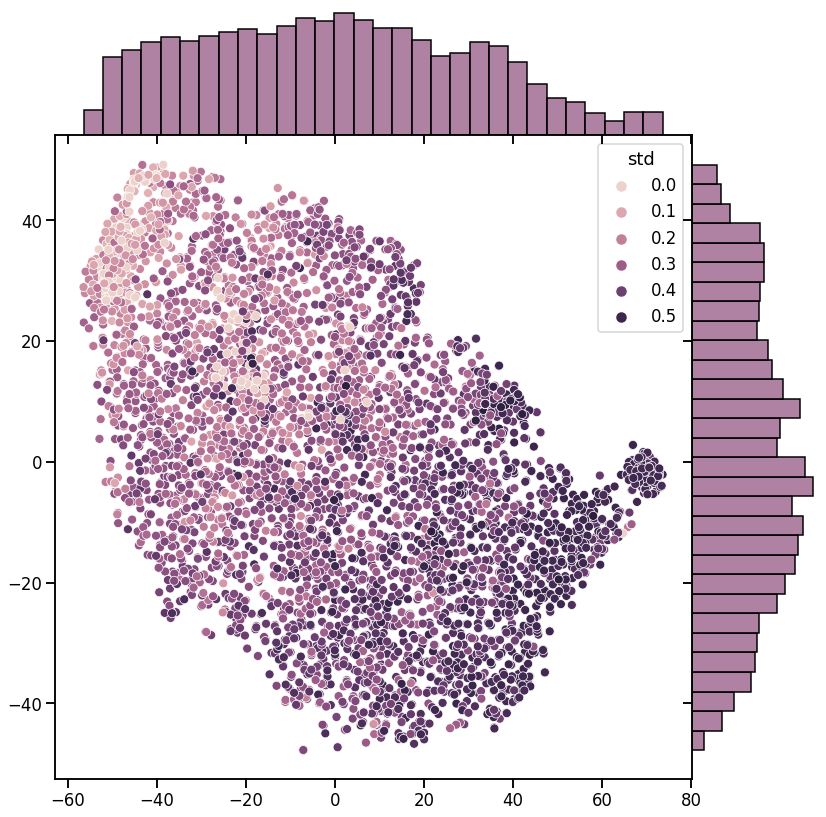

In [7]:
sns.set_context("talk")

plt.figure(figsize=(12,10))
df = annotators_embeddings_df.loc[:, ['x', 'y', 'attack_mean', 'attack_std', 'attack_count']]
#df = annotators_embeddings_df.loc[:, ['x', 'y', 'aggression_mean', 'aggression_std', 'aggression_count']]

df.columns = ['x', 'y', 'mean', 'std', 'count']
#df = df[df['count'] > 200]
#df = df[(df.x > -60) & (df.x < -30) & (df.y > 30) & (df.y < 50)] 

g = sns.JointGrid(data=df, x="x", y="y", height=12, space=0)
sns.scatterplot(data=df, x="x", y="y", hue='mean', ax=g.ax_joint)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')

sns.histplot(data=df, x="x", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_x, bins=30)
sns.histplot(data=df, y="y", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_y, bins=30)

plt.savefig('annotator_embeddings_mean.pdf', dpi=300)
plt.show()

plt.figure(figsize=(12,10))

g = sns.JointGrid(data=df, x="x", y="y", height=12, space=0)
sns.scatterplot(data=df, x="x", y="y", hue='std', ax=g.ax_joint)
#g.ax_joint.set_xticks([])
#g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')

sns.histplot(data=df, x="x", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_x, bins=30)
sns.histplot(data=df, y="y", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_y, bins=30)

#plt.savefig('annotator_embeddings_std.pdf', dpi=300)

In [8]:
ann_ids = df[(df.x > 57) & (df.x < 80) & (df.y > -10) & (df.y < 1)].index.tolist()

In [11]:
annotations_df = data_module.annotations
annotations_df[annotations_df.annotator_id.isin(ann_ids)].merge(data_module.data)

,text_id,annotator_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack,fold,text,year,logged_in,ns,sample,split
0,128532,2671,0.0,0.0,0.0,0.0,0.0,4,"`Someone wrote: More recognizable, perhaps, i...",2002,True,article,random,train
1,336654,3810,0.0,0.0,0.0,0.0,0.0,2,":I have checked the licenses, and it is pu...",2002,True,user,random,dev
2,583986,3810,0.0,0.0,0.0,0.0,0.0,2,"Dear Mav: Thanks, bro! God bless you! ...",2003,True,user,random,train
3,593977,2891,0.0,0.0,0.0,0.0,0.0,4,"` That's true. I removed similar passages, ...",2003,True,article,random,test
4,707010,2632,0.0,0.0,0.0,0.0,0.0,9,The link to SGC Belfry Ted Nude-Gent is dead. ...,2003,False,article,blocked,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20837,699659494,3918,0.0,0.0,0.0,0.0,0.0,7,im soory since when is google images not allow...,2016,True,user,blocked,dev
20838,699663770,3420,0.0,1.0,0.0,0.0,1.0,7,== hi Drmies == My name's Little Cletus...,2016,True,user,blocked,train
20839,699663770,3897,0.0,1.0,0.0,0.0,1.0,6,== hi Drmies == My name's Little Cletus...,2016,True,user,blocked,train
20840,699698850,2550,0.0,0.0,0.0,1.0,1.0,0,"Yeah, I realized I created a duplicate ID....",2016,True,user,blocked,test


In [12]:
ann_ids = df[(df.x > 57) & (df.x < 80) & (df.y > -10) & (df.y < 1)].index.tolist()

In [23]:
aggressive_ann_ids = [189,
 274,
 413,
 1187,
 2076,
 2512,
 2850,
 2863,
 2864,
 2905,
 2935,
 2949,
 3418,
 3419,
 3420,
 3431,
 3435,
 3436,
 3437,
 3438,
 3464,
 3532,
 3537,
 3538,
 3544,
 3545,
 3548,
 3549,
 3564,
 3565,
 3574,
 3575,
 3577,
 3633,
 3636,
 3642,
 3646,
 3650,
 3651,
 3652,
 3653,
 3654,
 3731,
 3748,
 3766,
 3842,
 3843,
 3846,
 3865,
 3867,
 3871,
 3894,
 3896,
 3897,
 3908,
 3910,
 3914,
 3916,
 3918,
 3945,
 3946,
 3947,
 3948,
 3949,
 3952,
 3954,
 3955,
 3957,
 3958,
 3959,
 3979,
 3981,
 3983,
 3984,
 3985,
 3987,
 4007,
 4008,
 4011,
 4028,
 4031]
set(ann_ids).intersection(aggressive_ann_ids)
#len(set(ann_ids).union(aggressive_ann_ids))

{189,
 413,
 1187,
 2863,
 2864,
 2905,
 2935,
 2949,
 3418,
 3419,
 3420,
 3431,
 3436,
 3437,
 3438,
 3464,
 3532,
 3537,
 3538,
 3544,
 3545,
 3548,
 3549,
 3564,
 3565,
 3574,
 3575,
 3577,
 3633,
 3636,
 3650,
 3651,
 3652,
 3653,
 3654,
 3731,
 3748,
 3766,
 3842,
 3843,
 3846,
 3867,
 3871,
 3894,
 3896,
 3897,
 3908,
 3910,
 3914,
 3918,
 3945,
 3946,
 3947,
 3948,
 3949,
 3952,
 3954,
 3955,
 3957,
 3958,
 3959,
 3979,
 3981,
 3983,
 3984,
 3985,
 3987,
 4007,
 4008,
 4011,
 4028,
 4031}

In [40]:
aggressive_annotator_ids = 

[189,
 413,
 565,
 1187,
 1278,
 1782,
 2550,
 2562,
 2632,
 2671,
 2701,
 2863,
 2864,
 2891,
 2900,
 2905,
 2935,
 2949,
 2954,
 2974,
 3056,
 3219,
 3277,
 3418,
 3419,
 3420,
 3431,
 3434,
 3436,
 3437,
 3438,
 3464,
 3494,
 3507,
 3532,
 3537,
 3538,
 3544,
 3545,
 3548,
 3549,
 3564,
 3565,
 3574,
 3575,
 3577,
 3633,
 3636,
 3650,
 3651,
 3652,
 3653,
 3654,
 3719,
 3731,
 3748,
 3766,
 3787,
 3810,
 3842,
 3843,
 3846,
 3867,
 3871,
 3882,
 3894,
 3896,
 3897,
 3908,
 3910,
 3914,
 3918,
 3931,
 3945,
 3946,
 3947,
 3948,
 3949,
 3952,
 3954,
 3955,
 3957,
 3958,
 3959,
 3979,
 3980,
 3981,
 3983,
 3984,
 3985,
 3987,
 4007,
 4008,
 4011,
 4013,
 4022,
 4028,
 4031]